In [11]:
from __future__ import print_function,division
import os
import torch
import pandas as pd    #For easier csv parsing
from skimage import io,transform   #For image io and transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion()   #interactive mode

In [12]:
landmarks_frame=pd.read_csv('faces/face_landmarks.csv')  #加载图片的landmarks
#显示第65张图片的landmarks信息
print(len(landmarks_frame))    #Dataset的函数，输出数据集大小
n=65
img_name=landmarks_frame.iloc[n,0]
landmarks=landmarks_frame.iloc[n,1:].as_matrix()
landmarks=landmarks.astype('float').reshape(-1,2)

print('Image name:{}'.format(img_name))
print('Landmarks shape:{}'.format(landmarks.shape))
print('First 4 Landmarks:{}'.format(landmarks[:4]))

69
Image name:person-7.jpg
Landmarks shape:(68, 2)
First 4 Landmarks:[[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


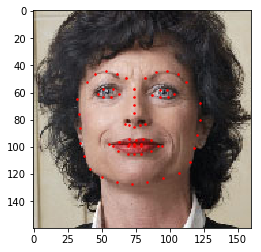

In [13]:
#显示一张图片和landmarks,show image with landmarks
def show_landmarks(image,landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1],s=10,marker='.',c='r')
    plt.pause(0.001)  #pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/',img_name)),landmarks)
plt.show()

In [14]:
class FaceLandmarksDataset(Dataset):   #继承Dataset类，表示数据集
    """Face landmarks dataset"""
    def __init__(self,csv_file,root_dir,transform=None):
        """
        Args:
            csv_file(string):Path to the csv file with annotations
            root_dir(string):Directory with all the images
            transform(callable,optional):Optional transform to be applied on a sample
        """
        self.landmarks_frame=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
    
    def __len__(self):  #重写len方法，返回数据集大小
        return len(self.landmarks_frame)
    
    #使用下标获取第i个样本
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.landmarks_frame.iloc[idx,0])   #图片路径
        image=io.imread(img_name)   #读出图片
        landmarks=self.landmarks_frame.iloc[idx,1:].as_matrix()
        landmarks=landmarks.astype('float').reshape(-1,2)
        sample={'image':image,'landmarks':landmarks}    #数据集以字典的形式保存，{图片，关键点}
        
        if self.transform:
            sample=self.transform(sample)
        
        return sample

0 (324, 215, 3) (68, 2)


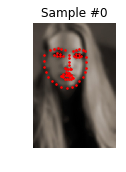

1 (500, 333, 3) (68, 2)


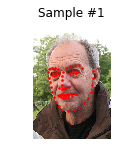

2 (250, 258, 3) (68, 2)


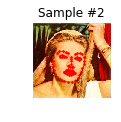

3 (434, 290, 3) (68, 2)


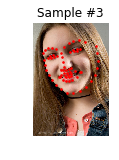

In [15]:
#实例化Dataset类，输出前4个和他们的关键点
face_dataset=FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',root_dir='faces/')
fig=plt.figure()

for i in range(len(face_dataset)):
    sample=face_dataset[i]
    print(i,sample['image'].shape,sample['landmarks'].shape)
    
    ax=plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis('off')   #不显示坐标轴
    show_landmarks(**sample)
    
    if i==3:
        plt.show()
        break

In [28]:
#Rescale the image in a sample to a given size
class Rescale(object):
    """
    Args:
        output_size(tuple or int): Desired output size. If tuple, output is matched to output_size. 
        If int, smaller of image edges is matched to output_size keeping aspect ratio the same
    """
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        self.output_size=output_size
        
    def __call__(self,sample):
        image,landmarks=sample['image'],sample['landmarks']
        h,w=image.shape[:2]
        
        if isinstance(self.output_size,int):
            if h>w:
                new_h,new_w=self.output_size*h/w,self.output_size
            else:
                new_h,new_w=self.output_size,self.output_size*w/h
        else:
            new_h,new_w=self.output_size
        
        new_h,new_w=int(new_h),int(new_w)
        img=transform.resize(image,(new_h,new_w))
        landmarks=landmarks*[new_w/w,new_h/h]
        return {'image':img,'landmarks':landmarks}

#Crop randomly the image in a sample
class RandomCrop(object):
    """
    Args:
        output_size(tuple or int):期望的输出大小，如果是int 则裁剪出方形
    """
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        if isinstance(output_size,int):
            self.output_size=(output_size,output_size)   #元组tuple形式
        else:
            assert len(output_size)==2
            self.output_size=output_size
        
    def __call__(self,sample):
        image,landmarks=sample['image'],sample['landmarks']
        h,w=image.shape[:2]
        new_h,new_w=self.output_size
        
        top=np.random.randint(0,h-new_h)
        left=np.random.randint(0,w-new_w)
        
        image=image[top:top+new_h,left:left+new_w]
        landmarks=landmarks-[left,top]
        return {'image':image,'landmarks':landmarks}

#Convert ndarrays in sample to Tensors
class ToTensor(object):
    def __call__(self,sample):
        image,landmarks=sample['image'],sample['landmarks']
        
        #swap color axis,because numpy image:(h,w,c) torch image:(c,h,w)
        image=image.transpose((2,0,1))
        return {'image':torch.from_numpy(image),'landmarks':torch.from_numpy(landmarks)}

(324, 215, 3)
(385, 256, 3)


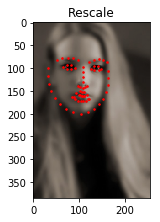

(128, 128, 3)


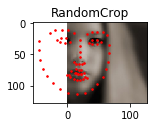

(224, 224, 3)


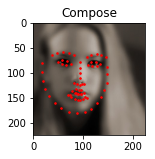

In [31]:
#对图片进行调整大小、裁剪及组合操作
scale=Rescale(256)
crop=RandomCrop(128)
composed=transforms.Compose([Rescale(256),RandomCrop(224)])

#Apply each of the above transforms on sample
plt.figure()
sample=face_dataset[0]
print(sample['image'].shape)
for i,tsfrm in enumerate([scale,crop,composed]):
    transformed_sample=tsfrm(sample)
    ax=plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    print(transformed_sample['image'].shape)
    show_landmarks(**transformed_sample)

plt.show()

In [32]:
#对所有图片调整大小、裁剪，变成同样大小
transformed_dataset=FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                         root_dir='faces/',
                                         transform=transforms.Compose([
                                             Rescale(256),
                                             RandomCrop(224),
                                             ToTensor()
                                         ]))
for i in range(len(transformed_dataset)):
    sample=transformed_dataset[i]
    print(i,sample['image'].shape,sample['landmarks'].shape)
    
    if i==3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
image 0 torch.Size([3, 224, 224]) torch.Size([68, 2])
image 1 torch.Size([3, 224, 224]) torch.Size([68, 2])
image 2 torch.Size([3, 224, 224]) torch.Size([68, 2])
image 3 torch.Size([3, 224, 224]) torch.Size([68, 2])


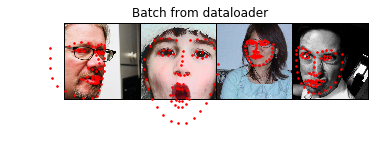

In [41]:
dataloader=DataLoader(transformed_dataset,batch_size=4,shuffle=True,num_workers=0)

#helper function to show a batch
def show_landmarks_batch(sample_batched):
    images_batch,landmarks_batch=sample_batched['image'],sample_batched['landmarks']
    batch_size=len(images_batch)
    im_size=images_batch.size(2)
    
    grid=utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1,2,0))
    
    for i in range(batch_size):
        print('image',i,images_batch[i].size(),landmarks_batch[i].size())
        plt.scatter(landmarks_batch[i,:,0].numpy()+i*im_size,
                    landmarks_batch[i,:,1].numpy(),s=10,marker='.',c='r')
        plt.title("Batch from dataloader")
    
for i_batch,sample_batched in enumerate(dataloader):
    #输出每个batch的图片大小、关键点的大小
    print(i_batch,sample_batched['image'].size(),sample_batched['landmarks'].size())
    
    #observe ith batch and stop
    if i_batch==2:
        plt.figure
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break